In [1]:
import os
import pandas as pd
import csv
import numpy as np
from joblib import dump, load
import h5py

from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
%matplotlib notebook

import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [4]:
def correct_length(pos_list):
    for i in range(len(pos_list)):
        if len(pos_list[i]) == 20:
            continue
        elif len(pos_list[i]) > 20:
            pos_list[i] = pos_list[i][0:20]
        else:
            for j in range(20 - len(pos_list[i])):
                pos_list[i].append(np.nan)
    return pos_list

def load_csv_data(filepath):
    
    with open(filepath,'r',newline='') as f:
        csv_reader = csv.reader(f)
        
        data_1 = []
        data_2 = []
        counter = 0
        
        for row in csv_reader:
            try:
                data_1.append([float(i) for i in (row[0][1:-1]).split(', ')])
                data_2.append([float(i) for i in (row[1][1:-1]).split(', ')])
            except:
                counter += 1
                data_1.append([np.nan for i in range(20)])
                data_2.append([np.nan for i in range(20)])
            
    print(counter)
    return [correct_length(data_1), correct_length(data_2)]

In [5]:
# orignal instances
file_paths_or = ["../predictions/20201119/bottomup/pred_FishTank20200416_160648/results/FishTank20200416_160648/FishTank20200416_160648.h5"]
original_instances = []
for file_path in file_paths_or:
    with h5py.File(file_path, 'r') as f:
        original_instances.append(np.copy(f['original_instances']))
        
# 2d datasets "Old"
set_old = [load_csv_data('spinexz_points20.csv'), load_csv_data('spine0_20.csv'),
           load_csv_data('spineyz_points20.csv')]

# 2d datasets "New"
set_new = [load_csv_data('spinexz_points20_2.csv'), load_csv_data('spinexy_points20_2.csv'),
           load_csv_data('spineyz_points20_2.csv')]

7554
237
31884
7917
265
32885


In [4]:
for i in original_instances:
    print(i)

[[[[[338.0135498  910.09570312]
    [358.04786682 914.04699707]
    [404.02268982 921.93389893]]]


  [[[338.02230835 910.07995605]
    [358.0473175  914.04034424]
    [404.03881836 921.91033936]]]


  [[[338.02145386 910.07904053]
    [358.06188965 914.03869629]
    [404.0793457  921.90875244]]]


  ...


  [[[313.92874146 894.01275635]
    [316.03973389 891.94567871]
    [324.03378296 883.98272705]]]


  [[[313.94952393 894.04760742]
    [316.07099915 891.96014404]
    [324.05973816 883.98986816]]]


  [[[314.05670166 895.91418457]
    [318.00140381 890.06219482]
    [325.94511414 883.95770264]]]]



 [[[[849.07678223 342.99241638]
    [835.04602051 345.0566864 ]
    [801.03619385 357.01620483]]]


  [[[849.07373047 343.02380371]
    [835.04528809 345.07145691]
    [801.0300293  356.98840332]]]


  [[[849.08056641 343.05961609]
    [835.05090332 345.08827209]
    [801.01031494 356.97924805]]]


  ...


  [[[870.94024658 353.01364136]
    [868.94146729 368.94616699]
    [864.90032959 

In [6]:
class Calibration(object):
    ''' A class for loading and using the calibrations for the cameras
    
    -- Methods --
    compute_imageCoord_triplet_from_XYZ
    compute_XYZ_from_imageCoord_triplet
    compute_XZ_imcoords_from_XY_YZ
    compute_XY_imcoords_from_XZ_YZ
    compute_YZ_imcoords_from_XZ_XY
    compute_point_correspondence_error
    
    '''
    
    def __init__(self, calibration_folder_path):
        ''' Instantiate the object
        
        -- args --
        calibration_folder_path: the path to a calibration folder, where the regressed functions
                                 have already been computed and saved
                                 
        '''
        # record the folder paths
        self.calibration_folder_path = calibration_folder_path
        self.python_calibration_folderPath = os.path.join(self.calibration_folder_path, 
                                                          'python_calibration_models')
        
        # load the models and assign as attributes
        self._load_models()
        
    
    def _load_models(self):
        ''' Instantiate the regression object attributes:
            xyz_getter, imCoord_getter, xz_getter, xy_getter, yz_getter 
        '''
        imCoords_to_XYZ_path = os.path.join(self.python_calibration_folderPath, 'imCoords_to_XYZ.joblib')
        XYZ_to_imCoords_path = os.path.join(self.python_calibration_folderPath, 'XYZ_to_imCoords.joblib')
        xy_yz_to_xz_path = os.path.join(self.python_calibration_folderPath, 'xy_yz_to_xz.joblib')
        xz_yz_to_xy_path = os.path.join(self.python_calibration_folderPath, 'xz_yz_to_xy.joblib')
        xz_xy_to_yz_path = os.path.join(self.python_calibration_folderPath, 'xz_xy_to_yz.joblib')
        
        self.xyz_getter = load(imCoords_to_XYZ_path)
        self.imCoord_getter = load(XYZ_to_imCoords_path)
        self.xz_getter = load(xy_yz_to_xz_path)
        self.xy_getter = load(xz_yz_to_xy_path)
        self.yz_getter = load(xz_xy_to_yz_path)
        return
    
    
    # ---- Main Methods ---- #
    
    def compute_imageCoord_triplet_from_XYZ(self, XYZ):
        ''' Predict the image coordinates in all 3 camera views of the
            3D point XYZ
            
        -- inputs --
        XYZ: array (3,), the position of a point in 3D
        
        -- returns --
        imCoords: array (3,2) of image coordinates in standard camera
                  order of XZ,XY,YZ
        '''
        imCoords = self.imCoord_getter.predict(XYZ.reshape(1,-1))
        imCoords = imCoords.reshape(3,2)
        return imCoords
    
    
    def compute_XYZ_from_imageCoord_triplet(self, imCoords):
        ''' Predict the XYZ position of the point given by the image
            coordinates from all 3 cameras

        -- Inputs --
        imCoords: array of shape (3,2)

        -- Outputs --
        XYZ: array of shape (3)

        '''
        XYZ = self.xyz_getter.predict(imCoords.reshape(-1,6))
        return XYZ
    
    
    def compute_XZ_imcoords_from_XY_YZ(self, xy_imCoord, yz_imCoord):
        ''' Given an image coordinate from both the XY and YZ views,
            compute the corresponding image coordinate from the XZ view

        -- args --
        xy_imCoord: image coordinate of shape (2,)
        yz_imCoord: image coordinate of shape (2,)

        -- returns --
        xz_imCoord: image coordinate of shape (2,)

        '''
        input_data = np.hstack((xy_imCoord, yz_imCoord)).reshape(1,4)
        xz_imCoord = self.xz_getter.predict(input_data)
        return xz_imCoord

    def compute_XY_imcoords_from_XZ_YZ(self, xz_imCoord, yz_imCoord):
        ''' Given an image coordinate from both the XZ and YZ views,
            compute the corresponding image coordinate from the XY view

        -- args --
        xz_imCoord: image coordinate of shape (2,)
        yz_imCoord: image coordinate of shape (2,)
        
        -- returns --
        xy_imCoord: image coordinate of shape (2,)
        '''
        # prepare the input for predictor, and predict the imcoord
        input_data = np.hstack((xz_imCoord, yz_imCoord)).reshape(1,4)
        xy_imCoord = self.xy_getter.predict(input_data)
        return xy_imCoord

    def compute_YZ_imcoords_from_XZ_XY(self, xz_imCoord, xy_imCoord):
        ''' Given an image coordinate from both the XY and YZ views,
            compute the corresponding image coordinate from the XZ view

        -- args --
        xz_imCoord: image coordinate of shape (2,)
        xy_imCoord: image coordinate of shape (2,)

        -- returns --
        yz_imCoord: image coordinate of shape (2,)

        '''
        # prepare the input for predictor, and predict the imcoord
        input_data = np.hstack((xz_imCoord, xy_imCoord)).reshape(1,4)
        yz_imCoord = self.yz_getter.predict(input_data)
        return yz_imCoord
    
    
    def compute_point_correspondence_error(self, camIdxs, imCoords_cam1, imCoords_cam2):
        ''' Compute the error of making a cross-camera association between these points

        -- args -- 
        camIdxs: a list denoting the cameras the imCoords args are coming from.
                 Has to be [0,1], [1,2], or [0, 2]
        imCoords_cam1: image coordinates from a camera
        imCoords_cam2: image coordinates from a different camera


        -- returns --
        error: a scalar error value for making this association 
        '''
        # STEP 0: The error is NaN if either point is NaN
        if np.all(np.isnan(imCoords_cam1)) or np.all(np.isnan(imCoords_cam2)):
            return np.NaN

        # STEP 1: Compute the proposed image coordinate triplet
        if camIdxs == [0,1]:
            # derive YZ
            imCoords_cam3 = self.compute_YZ_imcoords_from_XZ_XY(imCoords_cam1, imCoords_cam2)
            proposed_imCoords = np.vstack((imCoords_cam1, imCoords_cam2, imCoords_cam3))
        elif camIdxs == [0, 2]:
            # derive XY
            imCoords_cam3 = self.compute_XY_imcoords_from_XZ_YZ(imCoords_cam1, imCoords_cam2)
            proposed_imCoords = np.vstack((imCoords_cam1, imCoords_cam3, imCoords_cam2))
        elif camIdxs == [1, 2]:
            # derive XZ
            imCoords_cam3 = self.compute_XZ_imcoords_from_XY_YZ(imCoords_cam1, imCoords_cam2)
            proposed_imCoords = np.vstack((imCoords_cam3, imCoords_cam1, imCoords_cam2))


        # STEP 2: Compute the errors

        # For each pairing of cameras, compute the 3rd cam image coordinate,
        # then compare this triplet to the proposed_imCoords, which act as truth
        # Note1: If this is a good pairing, then proposed_imCoords represent the same point in 3D
        # Note2: for one of these camera pairings test, we will get back an error of 0,
        #        since we did the same computation to compute proposed_coordinates.
        # Note3: to deal with note2, we define the error as the maximum of the 3 errors
        derived_xz = self.compute_XZ_imcoords_from_XY_YZ(proposed_imCoords[1], proposed_imCoords[2])
        image_coords_derXZ = np.vstack((derived_xz, proposed_imCoords[1], proposed_imCoords[2]))
        error_derXZ = np.linalg.norm(proposed_imCoords - image_coords_derXZ)

        derived_xy = self.compute_XY_imcoords_from_XZ_YZ(proposed_imCoords[0], proposed_imCoords[2])
        image_coords_derXY = np.vstack((proposed_imCoords[0], derived_xy, proposed_imCoords[2]))
        error_derXY = np.linalg.norm(proposed_imCoords - image_coords_derXY)

        derived_yz = self.compute_YZ_imcoords_from_XZ_XY(proposed_imCoords[0], proposed_imCoords[1])
        image_coords_derYZ = np.vstack((proposed_imCoords[0], proposed_imCoords[1], derived_yz))
        error_derYZ = np.linalg.norm(proposed_imCoords - image_coords_derYZ)

        errors = np.vstack((error_derXY, error_derXY, error_derYZ))
        error = np.sum(errors)

        return error

In [7]:
# calibration folder
calibrationFolderPath = '/home/thomasreus/Documents/Project/LargeCrop/20200325_calibration/shared_20200907/'
# calibration object
cal = Calibration(calibrationFolderPath)

In [6]:
print(np.array(original_instances[0]).shape)

(3, 573978, 1, 3, 2)


In [7]:
print(np.array(set_old[1][0]).shape)

(573978, 20)


In [8]:
def original_corr_sweep(original_instances):
    camIdxs = [[0,1], [0,2], [1,2]]
    error_lists = []
    
    for camIds in camIdxs:
        error_time = [[] for i in range(3)]
        for frame in range(600):
            for point in range(3):
                imCoords_cam1 = [original_instances[0][camIds[0]][frame][0][1][0],
                                 original_instances[0][camIds[0]][frame][0][1][1]]
                imCoords_cam2 = [original_instances[0][camIds[1]][frame][0][1][0],
                                 original_instances[0][camIds[1]][frame][0][1][1]]
                
                error_time[point].append(cal.compute_point_correspondence_error(camIds, imCoords_cam1, imCoords_cam2))
                
        error_lists.append(error_time)
        print("done")
    
    return error_lists

In [17]:
def correspondence_sweep(dataset, original_instances, extra_change=False):

    camIdxs = [[0,1], [0,2], [1,2]]
    error_lists = []
    
    for camIds in camIdxs:
        
        error_time = [[] for i in range(20)]
        
        for frame in range(60000):
            
            for point in range(20):
                
                extra_0 = 100
                extra_1 = 100
                
                if extra_change:
                    if camIds[0] == 1:
                        extra_0 = 60
                    if camIds[1] == 1:
                        extra_1 = 60
                
                imCoords_cam1 = [dataset[camIds[0]][0][frame][point] - extra_0 + 
                                 original_instances[0][camIds[0]][frame][0][1][0],
                                 dataset[camIds[0]][1][frame][point] - extra_0 + 
                                 original_instances[0][camIds[0]][frame][0][1][1]]
                imCoords_cam2 = [dataset[camIds[1]][0][frame][point] - extra_1 + 
                                 original_instances[0][camIds[1]][frame][0][1][0],
                                 dataset[camIds[1]][1][frame][point] - extra_1 + 
                                 original_instances[0][camIds[1]][frame][0][1][1]]
                
                error_time[point].append(cal.compute_point_correspondence_error(camIds, imCoords_cam1, imCoords_cam2))
                
        error_lists.append(error_time)
        print("done")
        
    return error_lists

In [18]:
old_set_sweep = correspondence_sweep(set_old, original_instances, True)
new_set_sweep = correspondence_sweep(set_new, original_instances)
original_sweep = original_corr_sweep(original_instances)

done
done
done
done
done
done
done
done
done


In [16]:
print(np.array(set_new).shape)
print(set_new[0][0][0][0])

(3, 2, 573978, 20)
79.86147872284282


In [42]:
print(np.array(old_set_sweep).shape)
print(old_set_sweep[0][0][1])
print([np.nanmean([new_set_sweep[0][i][j] for j in range(6000)]) for i in range(20)])

(3, 20, 6000)
8.423674162204545
[3.785110857603287, 3.7095364295391127, 3.797837295017899, 3.9754055377023474, 4.219313811200896, 4.2990530491835575, 4.453583478257268, 4.636373045121596, 4.816567505679042, 4.971741855256882, 5.080951250904025, 5.1299089267114555, 5.111764926446599, 5.033610057281436, 4.905596421104095, 4.763005907090467, 4.655864994754072, 5.231353747695838, 6.549416032060389, 8.268149537957774]


<IPython.core.display.Javascript object>


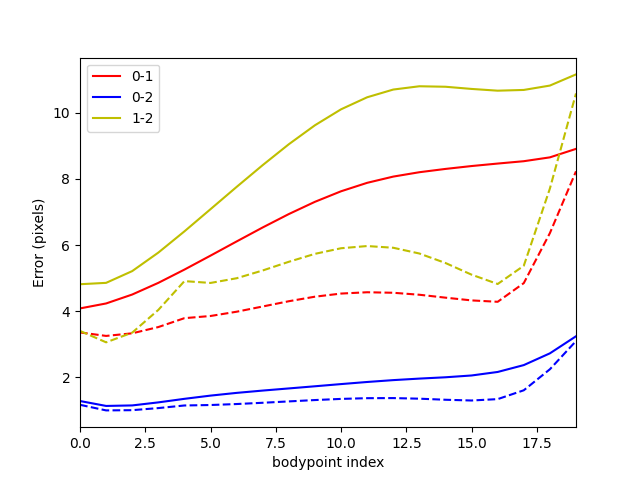

In [26]:
# plt.figure()
# plt.plot([np.nanmean([old_set_sweep[0][j][i] for j in range(20)]) for i in range(60000)], label="0-1")
# plt.plot([np.nanmean([old_set_sweep[1][j][i] for j in range(20)]) for i in range(60000)], label="0-2")
# plt.plot([np.nanmean([old_set_sweep[2][j][i] for j in range(20)]) for i in range(60000)], label="1-2")
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot([np.nanmean([new_set_sweep[0][j][i] for j in range(20)]) for i in range(600)], label="0-1")
# plt.plot([np.nanmean([new_set_sweep[1][j][i] for j in range(20)]) for i in range(600)], label="0-2")
# plt.plot([np.nanmean([new_set_sweep[2][j][i] for j in range(20)]) for i in range(600)], label="1-2")
# plt.legend()
# plt.show()

rx = 0
range_ = [rx,rx+60000]

plt.figure()
plt.plot([np.nanmean([old_set_sweep[0][i][j] for j in range(range_[0], range_[1])]) for i in range(20)], 'r-', label="0-1")
plt.plot([np.nanmean([old_set_sweep[1][i][j] for j in range(range_[0], range_[1])]) for i in range(20)], 'b-', label="0-2")
plt.plot([np.nanmean([old_set_sweep[2][i][j] for j in range(range_[0], range_[1])]) for i in range(20)], 'y-', label="1-2") 
plt.plot([np.nanmean([new_set_sweep[0][i][j] for j in range(range_[0], range_[1])]) for i in range(20)], 'r--')
plt.plot([np.nanmean([new_set_sweep[1][i][j] for j in range(range_[0], range_[1])]) for i in range(20)], 'b--')
plt.plot([np.nanmean([new_set_sweep[2][i][j] for j in range(range_[0], range_[1])]) for i in range(20)], 'y--')
plt.legend()
plt.ylabel("Error (pixels)")
plt.xlabel("bodypoint index (headstart)")
plt.xlim(0,19)
plt.show()

# plt.savefig('3D_check1.png', dpi=300)
# plt.figure()
# plt.plot([np.nanmean([original_sweep[0][i][j] for j in range(60000)]) for i in range(3)], label="0-1")
# plt.plot([np.nanmean([original_sweep[1][i][j] for j in range(60000)]) for i in range(3)], label="0-2")
# plt.plot([np.nanmean([original_sweep[2][i][j] for j in range(60000)]) for i in range(3)], label="1-2")
# plt.legend()
# plt.show()